In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names-shuffled.txt', 'r').read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {c:i+1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {v:k for k, v in stoi.items()}
vocab_size = len(itos)
print(vocab_size)

27


In [4]:
context_length = 3 # context length: number of chars used to predict the next char

def build_dataset(words):
    X, Y = [], [] # inputs and labels

    for w in words:
        context = [0] * context_length
        for c in w + '.':
            X.append(context)
            Y.append(stoi[c])
            context = context[1:] + [stoi[c]] # sliding the context by 1 character to right

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])      # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])      # 10%

torch.Size([404420, 3]) torch.Size([404420])
torch.Size([50599, 3]) torch.Size([50599])
torch.Size([50438, 3]) torch.Size([50438])


In [5]:
n_emb_dim = 10    # embedding dimensionality
n_hidden = 200    # neurons in hidden layers

g = torch.Generator().manual_seed(1337101)

C = torch.randn((vocab_size, n_emb_dim), generator=g, requires_grad=True)
W1 = torch.randn((context_length*n_emb_dim, n_hidden), generator=g, requires_grad=True)
b1 = torch.randn(n_hidden, generator=g, requires_grad=True)
W2 = torch.randn((n_hidden, vocab_size), generator=g, requires_grad=True)
b2 = torch.randn(vocab_size, generator=g, requires_grad=True)

parameters = [C, W1, b1, W2, b2]

print(f'Total Parameters: {sum(p.nelement() for p in parameters)}')

Total Parameters: 11897


In [6]:
epochs = 200000
batch_size = 24
lossi = []
g = torch.Generator().manual_seed(1337101)
for i in range(epochs):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # 24x3x10
    h = torch.tanh(emb.view(-1, context_length*n_emb_dim)@W1 + b1) # 24x200
    logits = h@W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # zero grads
    for p in parameters:
        p.grad = None
    
    # backpropagation
    loss.backward()

    # update weights
    lr = 0.1 if i < 100000 else 0.01  
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i%10000 == 0:
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 28.8719
  10000/ 200000: 2.1413
  20000/ 200000: 2.4915
  30000/ 200000: 2.4349
  40000/ 200000: 2.0656
  50000/ 200000: 1.9584
  60000/ 200000: 1.6457
  70000/ 200000: 2.2109
  80000/ 200000: 2.1679
  90000/ 200000: 2.4298
 100000/ 200000: 2.3428
 110000/ 200000: 2.2243
 120000/ 200000: 2.0568
 130000/ 200000: 1.5949
 140000/ 200000: 1.8363
 150000/ 200000: 1.8104
 160000/ 200000: 1.7116
 170000/ 200000: 1.9423
 180000/ 200000: 1.9226
 190000/ 200000: 1.5926


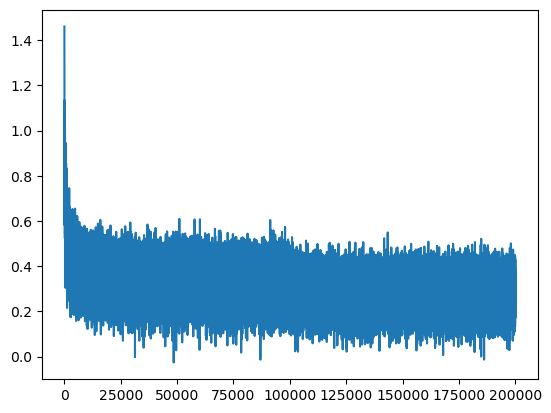

In [7]:
plt.plot(lossi)

In [8]:
@torch.no_grad() # disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x]
    h = torch.tanh(emb.view(-1, context_length*n_emb_dim)@W1 + b1)
    logits = h@W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')

train 1.9554104804992676
dev 1.967297911643982


In [9]:
g = torch.Generator().manual_seed(1337101+20)
for _ in range(20):
    context = [0]*context_length
    out = []
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(-1, context_length*n_emb_dim)@W1 + b1)
        logits = h@W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g, replacement=True)
        out.append(itos[ix.item()])
        context = context[1:] + [ix]
        if ix == 0:
            break
    print(''.join(out))

bhatchuundityanthevathika.
kavik.
aika.
hujana.
asha.
dijin.
eshana.
chi.
raj.
abha.
pranikha.
inthan.
sreecy.
abdrly.
ilsha.
keese.
bingenasmithrashandramigra.
puni.
sivajan.
iri.


### Fixing the initial loss

Initially the loss is very high: 0/ 200000: 27.1381 and it rapidly comes down to 2. So, the initial loss is very high.

In training of NN, we can always have a rough idea of what loss to expect at initialization.

At initialization, we don't have any reasons to believe that any character can be more likely than another. The prob distribution that comes out initially is a uniform distribution, assigning almost equal prob to all the 27 characters.

In [10]:
prob = 1/27.0
- torch.tensor(prob).log() # loss is negative log of prob

tensor(3.2958)

NLL of uniformly occuring charater is 3.2958 which is much much lesser than the initial loss reported by network i.e. 27.1381. NN is assigning unequal prob to charaters.

In [11]:
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

When the logits are close to 0, the probs are uniform. If the label is 2 or 3 or any, we'll get exact same loss because the distribution is uniform.

In [12]:
logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.0066, 0.0066, 0.9802, 0.0066]), tensor(0.0200))

Here we've increased the logits for one of the character, if the same character is the correct one, then the loss will be very low.

In [13]:
logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[3].log()
probs, loss

(tensor([0.0066, 0.0066, 0.9802, 0.0066]), tensor(5.0200))

If the logits with high value is not the correct character, then the loss will be very high.

In [14]:
# logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
logits = torch.randn(4)
probs = torch.softmax(logits, dim=0)
loss = -probs[3].log()
logits, probs, loss

(tensor([-0.4543, -0.5992,  1.0168, -0.0109]),
 tensor([0.1286, 0.1112, 0.5598, 0.2003]),
 tensor(1.6078))

Logits are normally distributed in the above example, which are centered around zero. So, the loss is not very high.

In [15]:
logits = torch.randn(4) *100
probs = torch.softmax(logits, dim=0)
loss = -probs[3].log()
logits, probs, loss

(tensor([  70.0166,   20.4685, -126.7838,  -12.3589]),
 tensor([1.0000e+00, 3.0306e-22, 0.0000e+00, 1.6780e-36]),
 tensor(82.3755))

But if the logits are very far apart as in above example, we might get extremely insane loss, even infinity at initialization.

So, we want the logits to be roughly zero when initializing.

NOTE: Logits don't have to be zero, they just have to be equal. We'll still get same loss as we get when logits are all zeros. But by symmetry we don't want them to be any +ve or -ve numbers, we want them all to be zeros.

Logits are calculated using the weights W2 and biases b2. If we want to make logits closer to zero initially, then we can set b2 to zero and make W2 very small.

In [16]:
n_emb_dim = 10    # embedding dimensionality
n_hidden = 200    # neurons in hidden layers

g = torch.Generator().manual_seed(1337101)

C = torch.randn((vocab_size, n_emb_dim), generator=g)
W1 = torch.randn((context_length*n_emb_dim, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # close to zero
b2 = torch.randn(vocab_size, generator=g) * 0 # initially zero

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print(f'Total Parameters: {sum(p.nelement() for p in parameters)}')

Total Parameters: 11897


In [17]:
epochs = 200000
batch_size = 24
lossi = []
g = torch.Generator().manual_seed(1337101)
for i in range(epochs):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # 24x3x10
    h = torch.tanh(emb.view(-1, context_length*n_emb_dim)@W1 + b1) # 24x200
    logits = h@W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # zero grads
    for p in parameters:
        p.grad = None
    
    # backpropagation
    loss.backward()

    # update weights
    lr = 0.1 if i < 100000 else 0.01  
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i%10000 == 0:
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3171
  10000/ 200000: 2.0346
  20000/ 200000: 2.4158
  30000/ 200000: 2.4136
  40000/ 200000: 1.5481
  50000/ 200000: 1.8058
  60000/ 200000: 1.5233
  70000/ 200000: 1.9131
  80000/ 200000: 2.2186
  90000/ 200000: 2.2227
 100000/ 200000: 2.2022
 110000/ 200000: 2.2272
 120000/ 200000: 1.9007
 130000/ 200000: 1.3326
 140000/ 200000: 1.9102
 150000/ 200000: 1.8716
 160000/ 200000: 1.7155
 170000/ 200000: 1.9173
 180000/ 200000: 1.7890
 190000/ 200000: 1.6435


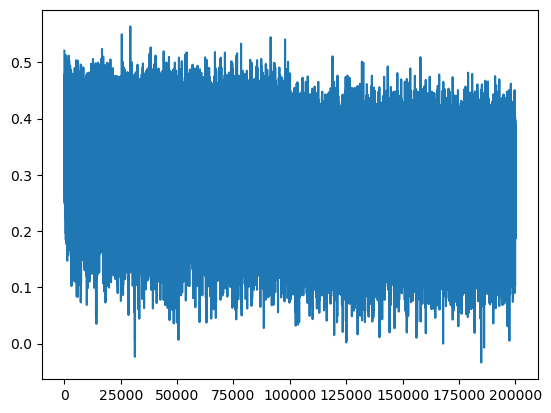

In [18]:
plt.plot(lossi)

No more hockey stick shape, because the initial loss is already realistic (close to what it actually should be).

In [19]:
split_loss('train')
split_loss('dev')
# losses improved a little. We're spending more time optimizing the NN actually, instead of just spending the initial cycles
# squashing down the weights.

train 1.9139622449874878
dev 1.931769609451294


### Fixing the saturated tanh

In [20]:
n_emb_dim = 10    # embedding dimensionality
n_hidden = 200    # neurons in hidden layers

g = torch.Generator().manual_seed(1337101)

C = torch.randn((vocab_size, n_emb_dim), generator=g)
W1 = torch.randn((context_length*n_emb_dim, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # close to zero
b2 = torch.randn(vocab_size, generator=g) * 0 # initially zero

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print(f'Total Parameters: {sum(p.nelement() for p in parameters)}')

Total Parameters: 11897


In [21]:
epochs = 200000
batch_size = 24
lossi = []
g = torch.Generator().manual_seed(1337101)
for i in range(epochs):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # 24x3x10
    h_pre_activation = emb.view(-1, context_length*n_emb_dim)@W1 + b1 # 24x200
    h = torch.tanh(h_pre_activation) # 24x200
    logits = h@W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # zero grads
    for p in parameters:
        p.grad = None
    
    # backpropagation
    loss.backward()

    # update weights
    lr = 0.1 if i < 100000 else 0.01  
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i%10000 == 0:
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 3.3171


In [22]:
h

tensor([[ 1.0000, -1.0000, -1.0000,  ...,  1.0000,  1.0000,  1.0000],
        [-1.0000,  0.7926,  0.9556,  ..., -1.0000,  0.9999, -0.2615],
        [ 1.0000, -0.2349, -0.9998,  ...,  0.9990,  1.0000,  1.0000],
        ...,
        [-0.9906,  0.8869,  0.8825,  ...,  0.8143, -1.0000, -0.9188],
        [ 0.9988, -0.9997, -0.9992,  ...,  0.9996,  0.9999,  0.0119],
        [-1.0000, -0.9996,  0.9995,  ..., -1.0000,  1.0000, -1.0000]],
       grad_fn=<TanhBackward0>)

Most of the values here are -1 or 1. tanh is a squashing function, it takes a value and squash it between -1 and 1

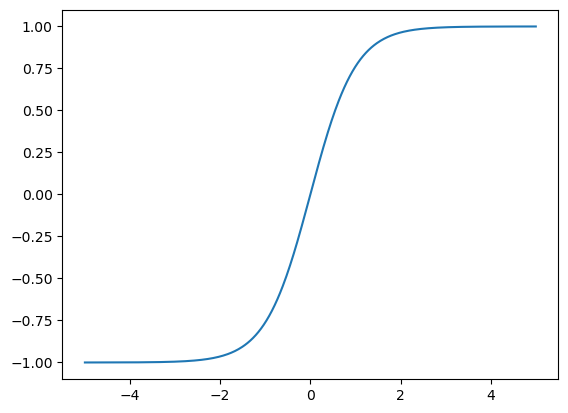

In [23]:
x = torch.linspace(-5, 5, 500)
plt.plot(x, torch.tanh(x));

torch.Size([24, 200])


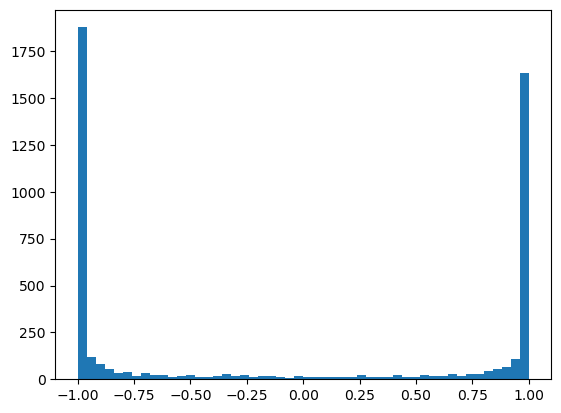

In [24]:
print(h.shape)
x = h.view(-1).tolist() # creating a single large list of h
plt.hist(x, bins=50);

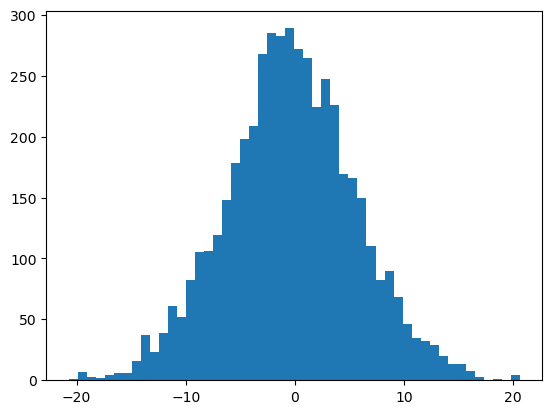

In [25]:
plt.hist(h_pre_activation.view(-1).tolist(), 50);

After applying tanh on h_pre_activation, most of the values take on -1 and +1. It is because in h_pre_activation the values are very broad, they are between -20 and +20 and applying tanh make these values -1 and +1

What happens to the gradients when the tanh is very close to -1 or +1?

    self.grad += (1.0 - tanh(x)**2) * out.grad

Whenever tanh(x) takes values closer to -1 or 1, the grad is almost zero and we're stopping the backpropagation through this tanh unit (out.grad won't propagate further).

When tanh(x) is zero, the out.grad passes as it is. This unit is sort of inactive and the gradient just passes through.

If you notice, the amount of out.grad always decreases ((1.0 - tanh(x)^2) * out.grad) when passed through tanh unit and it decreases perportionally to where you're in the tanh region. When you're in flat region (1.0 - tanh(x)^2) is close to zero and when in the slope region it is between 0 to 0.9999. 

In the flat regions of tanh, the derivative is close to zero, there's no impact on the loss on changing the weights of this perticular neuron.




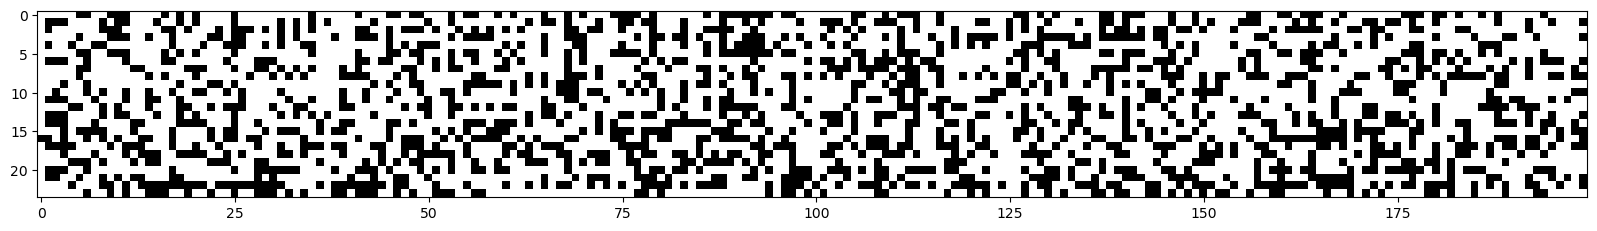

In [27]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest');

If h.abs()>0.99 is true then we get a white block and if it is false then we get a black block. For 24 examples and 200 neurons, a lot of blocks are white, means these neurons are very active and in the flat region and in all these cases the backward gradient will get destroyed.

If for any neuron the entire column is white then it will be a 'Dead Neuron'. It could be because none of the examples and weights are such that they cannot activate the tanh in the slope part. If all the examples land in the flat region, then this neuron will never learn.

Not just tanh, other activation functions can also have same issue. Some activation functions like ReLU, don't suffer from these problems as they don't have any flat regions.

#### How to fix this? ####

As we saw in above histograms, h_pre_activation is too far zero which is causing this issue. So we want h_pre_activation to be very closer to zero. To do so, very similarly what we did for initial loss, we can make the values of W1 and b1 closer to zero.

In [32]:
n_emb_dim = 10    # embedding dimensionality
n_hidden = 200    # neurons in hidden layers

g = torch.Generator().manual_seed(1337101)

C = torch.randn((vocab_size, n_emb_dim), generator=g)
W1 = torch.randn((context_length*n_emb_dim, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden, generator=g) * 0.01 # not exactly zero to get a little bit of entropy
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # close to zero
b2 = torch.randn(vocab_size, generator=g) * 0 # initially zero

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print(f'Total Parameters: {sum(p.nelement() for p in parameters)}')

Total Parameters: 11897


In [33]:
epochs = 200000
batch_size = 24
lossi = []
g = torch.Generator().manual_seed(1337101)
for i in range(epochs):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # 24x3x10
    h_pre_activation = emb.view(-1, context_length*n_emb_dim)@W1 + b1 # 24x200
    h = torch.tanh(h_pre_activation) # 24x200
    logits = h@W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # zero grads
    for p in parameters:
        p.grad = None
    
    # backpropagation
    loss.backward()

    # update weights
    lr = 0.1 if i < 100000 else 0.01  
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i%10000 == 0:
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 3.3103


torch.Size([24, 200])


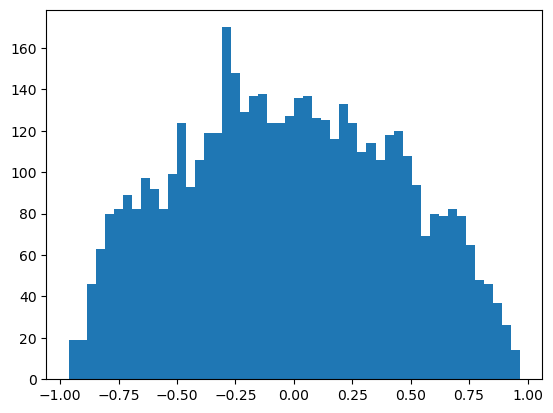

In [34]:
print(h.shape)
x = h.view(-1).tolist() # creating a single large list of h
plt.hist(x, bins=50);

All the values are between -1 and 1.

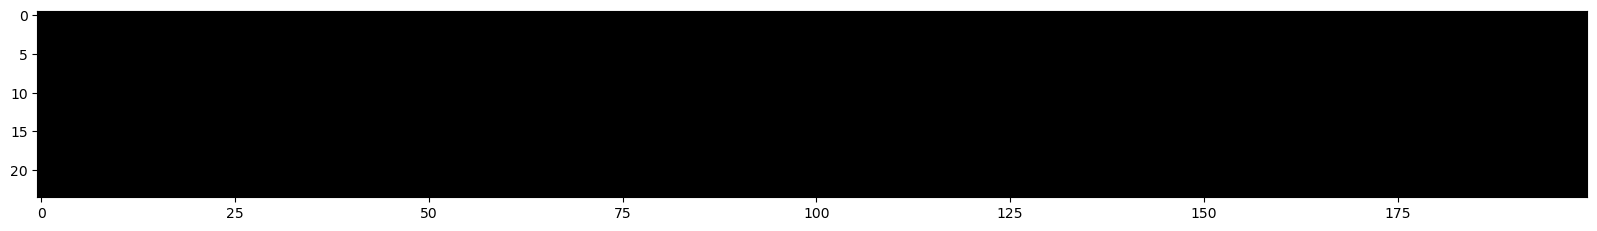

In [35]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest');

There are no whites as all the values are less than 0.99

In [36]:
n_emb_dim = 10    # embedding dimensionality
n_hidden = 200    # neurons in hidden layers

g = torch.Generator().manual_seed(1337101)

C = torch.randn((vocab_size, n_emb_dim), generator=g)
W1 = torch.randn((context_length*n_emb_dim, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden, generator=g) * 0.01 # not exactly zero to get a little bit of entropy
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # close to zero
b2 = torch.randn(vocab_size, generator=g) * 0 # initially zero

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print(f'Total Parameters: {sum(p.nelement() for p in parameters)}')

Total Parameters: 11897


In [37]:
epochs = 200000
batch_size = 24
lossi = []
g = torch.Generator().manual_seed(1337101)
for i in range(epochs):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # 24x3x10
    h_pre_activation = emb.view(-1, context_length*n_emb_dim)@W1 + b1 # 24x200
    h = torch.tanh(h_pre_activation) # 24x200
    logits = h@W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # zero grads
    for p in parameters:
        p.grad = None
    
    # backpropagation
    loss.backward()

    # update weights
    lr = 0.1 if i < 100000 else 0.01  
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i%10000 == 0:
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3103
  10000/ 200000: 1.9798
  20000/ 200000: 2.3085
  30000/ 200000: 2.3328
  40000/ 200000: 1.7211
  50000/ 200000: 1.8236
  60000/ 200000: 1.5235
  70000/ 200000: 1.9230
  80000/ 200000: 1.9988
  90000/ 200000: 2.1242
 100000/ 200000: 2.1119
 110000/ 200000: 2.1407
 120000/ 200000: 1.9213
 130000/ 200000: 1.3894
 140000/ 200000: 1.8884
 150000/ 200000: 1.9044
 160000/ 200000: 1.7438
 170000/ 200000: 2.0409
 180000/ 200000: 1.7386
 190000/ 200000: 1.5901


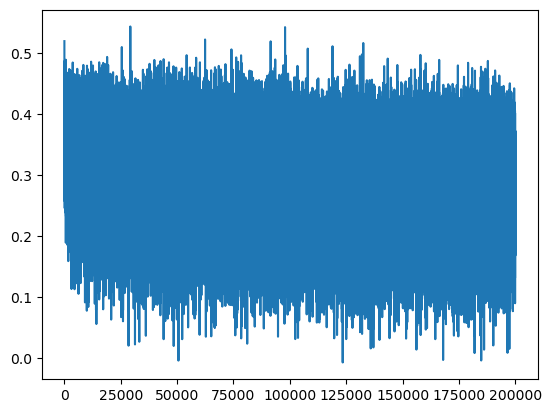

In [39]:
plt.plot(lossi);

In [40]:
split_loss('train')
split_loss('dev')

train 1.9178650379180908
dev 1.9279626607894897


### Batch Normalization ###

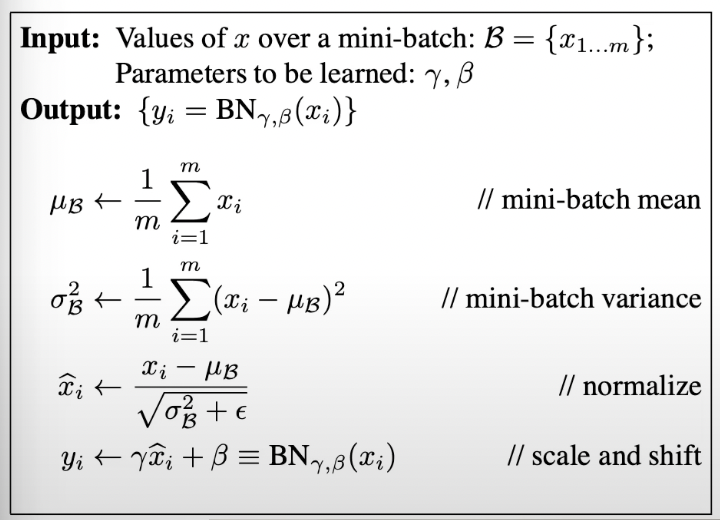

We want h_pre_activation to be roughly Gaussian because if h_pre_activation values are too small, then tanh will have no effect while backpropagation and if h_pre_activation values are too large, then it will lie in the flat region of tanh and while backpropagation the derivative will be zero.

So as per Batch Normalization paper, we can standardize these activations so that they are Gaussian.

We normalize a batch, that's why it is called Batch Normalization.

- Calculate the mean of all the outputs of neurons for a batch.
- Calculate the variance and standard deviation.
- From each value subtract the mean and divide by standard deviation.

All the above steps are perfectly differentiable and there won't be any issues while backpropagation.

We won't achieve very good result with this because we just want the activations to be Gaussian only during initialization and we don't want them to force to Gaussian always. We want this distribution of the graph to move around (left/right), more diffused or more sharp and we want the backpropagation to tell us how the distribution should the distribution move around.

**Scale & Shift -** We add 2 additional parameters shift and scale the distribution. These 2 parameters have gradients and are learned over time. These are called as **Gain** and **Bias**. Gain is multiplied to normalized output and Bias is added.

Gain is initialized with ones and Bias with zeros. Hence initially the distribution is Gaussian and later we will be able to backpropagate them so the network can optimize them.

In [42]:
n_emb_dim = 10    # embedding dimensionality
n_hidden = 200    # neurons in hidden layers

g = torch.Generator().manual_seed(1337101)

C = torch.randn((vocab_size, n_emb_dim), generator=g)
W1 = torch.randn((context_length*n_emb_dim, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden, generator=g) * 0.01 # not exactly zero to get a little bit of entropy
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # close to zero
b2 = torch.randn(vocab_size, generator=g) * 0 # initially zero

# batch normalization params
bn_gain = torch.ones((1, n_hidden))
bn_bias = torch.zeros((1, n_hidden))

# added bn_gain and bn_bias
parameters = [C, W1, b1, W2, b2, bn_gain, bn_bias]

for p in parameters:
    p.requires_grad = True

print(f'Total Parameters: {sum(p.nelement() for p in parameters)}')

Total Parameters: 12297


In [43]:
epochs = 200000
batch_size = 24
lossi = []
g = torch.Generator().manual_seed(1337101)
for i in range(epochs):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # 24x3x10
    h_pre_activation = emb.view(-1, context_length*n_emb_dim)@W1 + b1 # 24x200
    h_pre_activation = bn_gain * (h_pre_activation - h_pre_activation.mean(dim=0, keepdim=True))/h_pre_activation.std(dim=0, keepdim=True) + bn_bias # batch normalization
    h = torch.tanh(h_pre_activation) # 24x200
    logits = h@W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # zero grads
    for p in parameters:
        p.grad = None
    
    # backpropagation
    loss.backward()

    # update weights
    lr = 0.1 if i < 100000 else 0.01  
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i%10000 == 0:
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3135
  10000/ 200000: 1.9381
  20000/ 200000: 2.3515
  30000/ 200000: 2.3564
  40000/ 200000: 1.6386
  50000/ 200000: 1.7583
  60000/ 200000: 1.5455
  70000/ 200000: 1.9155
  80000/ 200000: 2.0888
  90000/ 200000: 2.1141
 100000/ 200000: 2.1032
 110000/ 200000: 2.3196
 120000/ 200000: 1.9277
 130000/ 200000: 1.4235
 140000/ 200000: 1.9269
 150000/ 200000: 1.9095
 160000/ 200000: 1.7811
 170000/ 200000: 1.9197
 180000/ 200000: 1.7770
 190000/ 200000: 1.6078


In [47]:
@torch.no_grad() # disables gradient tracking
def split_loss_bn(split):
    x, y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x]
    h_pre_activation = emb.view(-1, context_length*n_emb_dim)@W1 + b1
    h_pre_activation = bn_gain * (h_pre_activation - h_pre_activation.mean(dim=0, keepdim=True))/h_pre_activation.std(dim=0, keepdim=True) + bn_bias
    h = torch.tanh(h_pre_activation)

    logits = h@W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss_bn('train')
split_loss_bn('dev')

train 1.9186432361602783
dev 1.9269825220108032


**Mini-Batch Statistics Issue**

During training, BN normalizes the activations of each layer based on the mean and variance of the mini-batch which vary from one batch to another. This introduces noise into the activations (which can act as regularizer, preventing overfitting). During training, this noise is no longer present. The activations are on fixed mean and variance, leading to a different behaviour from what model experienced during training.

Another thing to notice here is, during validation we are calculating the mean and variance over the test set and using it to normalize the activations but we always don't have sets of data over which we can calculate these statistics. For example when the model is deployed we can input only a single input rather than having a complete set of inputs at that time mean and variance can't be calculated over a single data point.

Solutions:

- Calculate mean and variance at the end of training over the complete training set and use these while inference.
- Calculate mean and variance in a running manner during training.

Below we're going to use the 2nd solution.

In [45]:
n_emb_dim = 10    # embedding dimensionality
n_hidden = 200    # neurons in hidden layers

g = torch.Generator().manual_seed(1337101)

C = torch.randn((vocab_size, n_emb_dim), generator=g)
W1 = torch.randn((context_length*n_emb_dim, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden, generator=g) * 0.01 # not exactly zero to get a little bit of entropy
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # close to zero
b2 = torch.randn(vocab_size, generator=g) * 0 # initially zero

# batch normalization params
bn_gain = torch.ones((1, n_hidden))
bn_bias = torch.zeros((1, n_hidden))

# grads not required for these
bn_mean_running = torch.zeros((1, n_hidden))
bn_std_running = torch.ones((1, n_hidden))

# added bn_gain and bn_bias
parameters = [C, W1, b1, W2, b2, bn_gain, bn_bias]

for p in parameters:
    p.requires_grad = True

print(f'Total Parameters: {sum(p.nelement() for p in parameters)}')

Total Parameters: 12297


In [46]:
epochs = 200000
batch_size = 24
lossi = []
bn_momentum = 0.999
g = torch.Generator().manual_seed(1337101)
for i in range(epochs):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # 24x3x10
    h_pre_activation = emb.view(-1, context_length*n_emb_dim)@W1 + b1 # 24x200
    bn_meani = h_pre_activation.mean(dim=0, keepdim=True)
    bn_stdi = h_pre_activation.std(dim=0, keepdim=True)
    h_pre_activation = bn_gain * (h_pre_activation - bn_meani)/bn_stdi + bn_bias # batch normalization

    with torch.no_grad():
        bn_mean_running = bn_momentum * bn_mean_running + (1-bn_momentum) * bn_meani
        bn_std_running  = bn_momentum * bn_std_running  + (1-bn_momentum) * bn_stdi

    h = torch.tanh(h_pre_activation) # 24x200
    logits = h@W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # zero grads
    for p in parameters:
        p.grad = None
    
    # backpropagation
    loss.backward()

    # update weights
    lr = 0.1 if i < 100000 else 0.01  
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i%10000 == 0:
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3135
  10000/ 200000: 1.9381
  20000/ 200000: 2.3515
  30000/ 200000: 2.3564
  40000/ 200000: 1.6386
  50000/ 200000: 1.7583
  60000/ 200000: 1.5455
  70000/ 200000: 1.9155
  80000/ 200000: 2.0888
  90000/ 200000: 2.1141
 100000/ 200000: 2.1032
 110000/ 200000: 2.3196
 120000/ 200000: 1.9277
 130000/ 200000: 1.4235
 140000/ 200000: 1.9269
 150000/ 200000: 1.9095
 160000/ 200000: 1.7811
 170000/ 200000: 1.9197
 180000/ 200000: 1.7770
 190000/ 200000: 1.6078


In [48]:
@torch.no_grad() # disables gradient tracking
def split_loss_bn(split):
    x, y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x]
    h_pre_activation = emb.view(-1, context_length*n_emb_dim)@W1 + b1
    h_pre_activation = bn_gain * (h_pre_activation - bn_mean_running)/bn_std_running + bn_bias # using running mean and std
    h = torch.tanh(h_pre_activation)

    logits = h@W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss_bn('train')
split_loss_bn('dev')

train 1.91847562789917
dev 1.9271007776260376


**Redundant Bias**

During BN the biases are useless because we're calculating the mean and subtracting it from the activations, so the biases get cancelled.

*We'll remove the bias from the linear layer going forward*